In [ ]:
import numpy as np
import pandas
!pip uninstall scikit-learn -y

!pip install -U scikit-learn
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
# from sklearn import manifold
import plotly.express as px
from functools import partial
from collections import OrderedDict
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from itertools import zip_longest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
%matplotlib inline

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 23.1 MB 5.5 kB/s 


In [ ]:
train_data = pandas.read_csv('data/train_in.csv').to_numpy()
train_labels = pandas.read_csv('data/train_out.csv').to_numpy()
test_data = pandas.read_csv('data/test_in.csv').to_numpy()
test_labels = pandas.read_csv('data/test_out.csv').to_numpy()

In [ ]:
# Part-1
train_labels.shape = (train_labels.size,)
test_labels.shape = (test_labels.size,)
model = np.zeros((10,256))
for i, label in enumerate(train_labels):
  model[label] += train_data[i]
for i in range(10):
  model[i] /= np.count_nonzero(train_labels == i)
dists = []
for idx, first in enumerate(model[:-1]):
  for idx2, second in enumerate(model[idx+1:]):
    # np.linalg.norm gives euclidian distance between 2 
    dist = np.linalg.norm(first-second,ord=2)
    dists.append((dist,idx,idx+1+idx2))
#    print(f"Distance between cloud center of {idx} and {idx+1+idx2} is : {dist}")
for t in sorted(dists,key=lambda r: r[0])[:5]:
  print(f"Distance between cloud center of {t[1]} and {t[2]} is : {t[0]}")
  # Here, top 5 pairs that have nearest cloud centers and hardest to differentiate are listed!
print([x for x in dists if x[1]==0])

Distance between cloud center of 7 and 9 is : 5.426474119055888
Distance between cloud center of 4 and 9 is : 6.0104079308959975
Distance between cloud center of 3 and 5 is : 6.118750020921418
Distance between cloud center of 8 and 9 is : 6.40116586858544
Distance between cloud center of 5 and 6 is : 6.68862915054493
[(14.44960796590658, 0, 1), (9.334555870229641, 0, 2), (9.143733671882783, 0, 3), (10.769844437633486, 0, 4), (7.519296259597183, 0, 5), (8.16301949032239, 0, 6), (11.864555054634078, 0, 7), (9.90790173732039, 0, 8), (11.488874937417041, 0, 9)]


Computing PCA...
Computing Standard LLE embedding...
Computing t-SNE embeedding...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



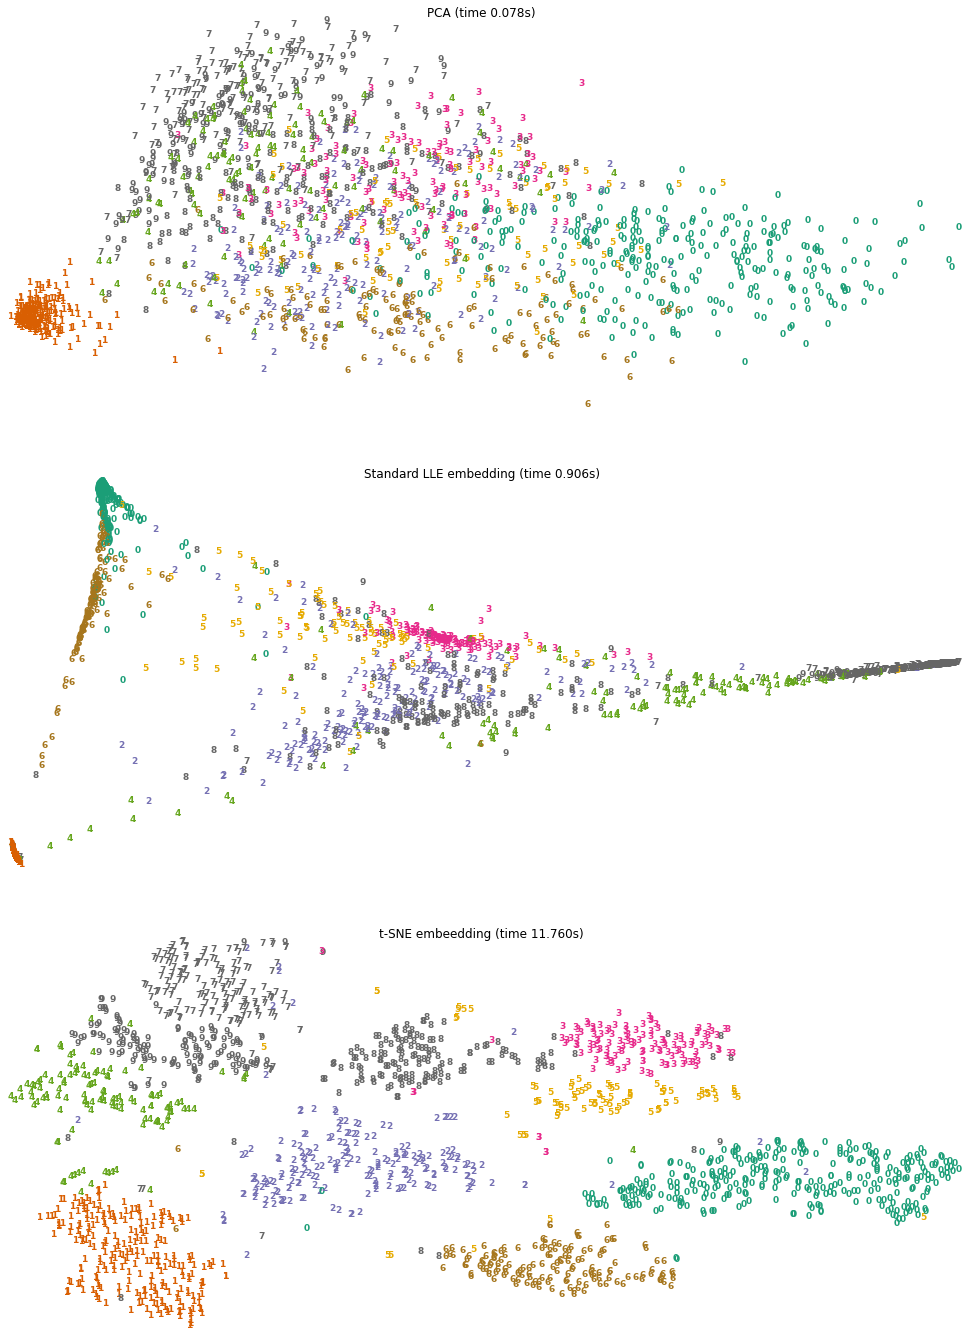

In [ ]:
# Part-2 Comparing PCA, LLE and TSNE
# visualizations taken from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py
X, y = train_data, train_labels
n_samples, n_features = X.shape
n_neighbors = 10

def plot_embedding(X, title, ax):
    X = MinMaxScaler().fit_transform(X)

    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        ax.text(
            X[i, 0],
            X[i, 1],
            str(y[i]),
            color=plt.cm.Dark2(y[i]),
            fontdict={"weight": "bold", "size": 9},
        )

        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)

    ax.set_title(title)
    ax.axis("off")

embeddings = {
    "PCA": PCA(
        n_components=2
    ),
    "Standard LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="standard"
    ),
    # "Modified LLE embedding": LocallyLinearEmbedding(
    #     n_neighbors=n_neighbors, n_components=2, method="modified"
    # ),
    "t-SNE embeedding": TSNE(
        n_components=2, init="pca", random_state=0
    ),
}

projections, timing = {}, {}
for name, transformer in embeddings.items():
    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(X, y)
    timing[name] = time() - start_time

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(17, 24))

for name, ax in zip_longest(timing, axs.ravel()):
    if name is None:
        ax.axis("off")
        continue
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title, ax)


In [ ]:
# part-3 distance based classifier
train_predictions = np.zeros((10,train_labels.size))
for idx in range(train_labels.size):
  for i in range(10):
    train_predictions[i][idx] = np.linalg.norm(model[i]-train_data[idx])

test_predictions = np.zeros((10,test_labels.size))
for idx in range(test_labels.size):
  for i in range(10):
    test_predictions[i][idx] = np.linalg.norm(model[i]-test_data[idx])

train_predictions = np.argmin(train_predictions, axis=0)
test_predictions = np.argmin(test_predictions, axis=0)
train_error_rate = 1 - np.count_nonzero(train_predictions==train_labels)/train_labels.size
test_error_rate = 1 - np.count_nonzero(test_predictions==test_labels)/test_labels.size
print(f"Train error rate: {train_error_rate}")
print(f"Test error rate: {test_error_rate}")


Train error rate: 0.1365767878077374
Test error rate: 0.19619619619619622


KNN train error rate: 0.054513481828839416
KNN test error rate: 0.10710710710710714


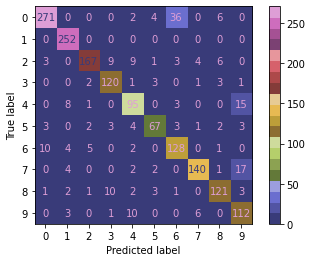

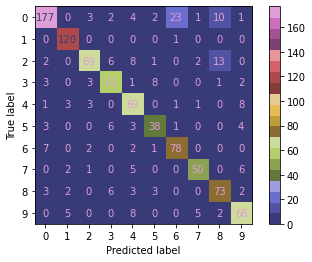

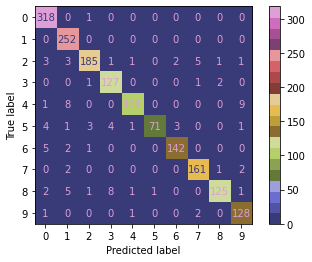

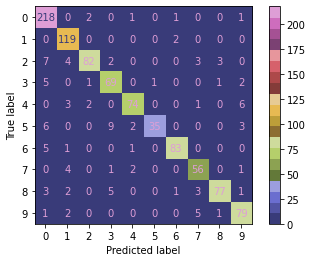

In [ ]:
# part-4 knn classifier
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(train_data, train_labels)
knn_train_predictions = knn.predict(train_data) 
knn_test_predictions = knn.predict(test_data)
knn_train_error_rate = 1 - np.count_nonzero(knn_train_predictions==train_labels)/train_labels.size
knn_test_error_rate = 1 - np.count_nonzero(knn_test_predictions==test_labels)/test_labels.size
print(f"KNN train error rate: {knn_train_error_rate}")
print(f"KNN test error rate: {knn_test_error_rate}")

import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(train_labels,train_predictions,cmap='tab20b')#, normalize='pred', values_format='.1f')
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions,cmap='tab20b')#, normalize='pred', values_format='.1f')
ConfusionMatrixDisplay.from_predictions(train_labels, knn_train_predictions,cmap='tab20b')#, normalize='pred', values_format='.1f')
ConfusionMatrixDisplay.from_predictions(test_labels, knn_test_predictions,cmap='tab20b')#, normalize='pred', values_format='.1f')

In [ ]:
print(sklearn.__version__)
# Make sure version is 1.0


1.0
